In [22]:
import numpy as np
import re
import csv
import time
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#%matplotlib notebook

In [2]:
WDAYS = ['Pirmadienis','Antradienis','Trečiadienis','Ketvirtadienis','Penktadienis','Šeštadienis','Sekmadienis']
MONTHS = ['Sausis','Vasaris','Kovas','Balandis','Gegužė','Birželis','Liepa','Rugpjūtis','Rugsėjis','Spalis','Lapkritis','Gruodis']
DATAFILE = '/home/valdo/Documents/BleNav-MIFBaltupiai/data/datamuse_2018.csv'

In [3]:
with open(DATAFILE) as f:
    reader = csv.reader(f)
    header = np.array(next(reader))
    data = np.array(list(reader))
header

array(['track_name', 'harness_code', 'track_start_time', 'track_end_time',
       'activity_start_time', 'activity_end_time', 'visit_id'],
      dtype='<U19')

In [4]:
data

array([['Mėlyna trasa', 'VL25', '2018-05-30 15:17:59.486697+00', ...,
        '2018-05-30 15:00:04.043937+00', '2018-05-30 16:04:38.096488+00',
        '13232'],
       ['Raudona trasa', 'VL25', '2018-05-30 16:04:38.096488+00', ...,
        '2018-05-30 15:00:04.043937+00', '2018-05-30 16:04:38.096488+00',
        '13232'],
       ['Žalia trasa', 'VL25', '2018-05-30 15:00:02.98905+00', ...,
        '2018-05-30 15:00:04.043937+00', '2018-05-30 16:04:38.096488+00',
        '13232'],
       ...,
       ['Žalia trasa', 'VM126', '2018-11-10 12:57:30.892639+00', ...,
        '2018-11-10 12:01:51.252127+00', '2018-11-10 13:05:22.410182+00',
        '22946'],
       ['Žalia trasa', 'VM126', '2018-11-10 12:50:59.622372+00', ...,
        '2018-11-10 12:01:51.252127+00', '2018-11-10 13:05:22.410182+00',
        '22946'],
       ['Žalia trasa', 'VM126', '2018-11-10 12:01:50.224108+00', ...,
        '2018-11-10 12:01:51.252127+00', '2018-11-10 13:05:22.410182+00',
        '22946']], dtype='<U29')

In [5]:
def f(s):
    if s == '': return 0.0
    return time.mktime(datetime.strptime(re.sub('\..*$', '', s), "%Y-%m-%d %H:%M:%S").timetuple())
vf = np.vectorize(f)

In [6]:
times = np.append(vf(data[:,2])[:,np.newaxis], vf(data[:,3])[:,np.newaxis], axis = 1)
times = np.append(times, vf(data[:,4])[:,np.newaxis], axis = 1)
times = np.append(times, vf(data[:,5])[:,np.newaxis], axis = 1)
times.shape

(29462, 4)

In [7]:
visits = data[:,6].astype(int)
visits.shape

(29462,)

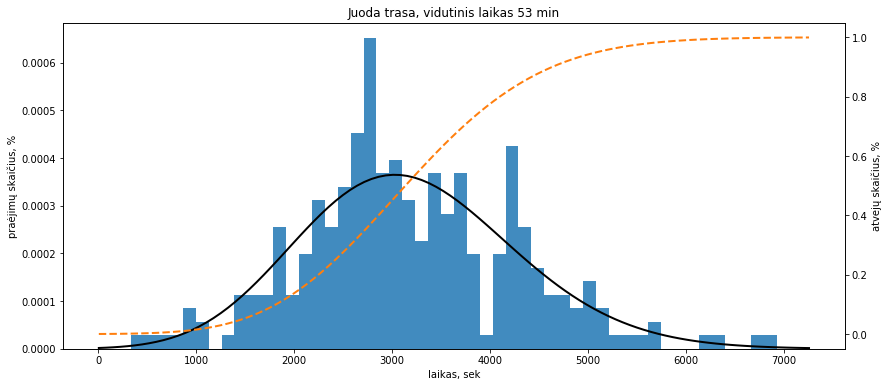

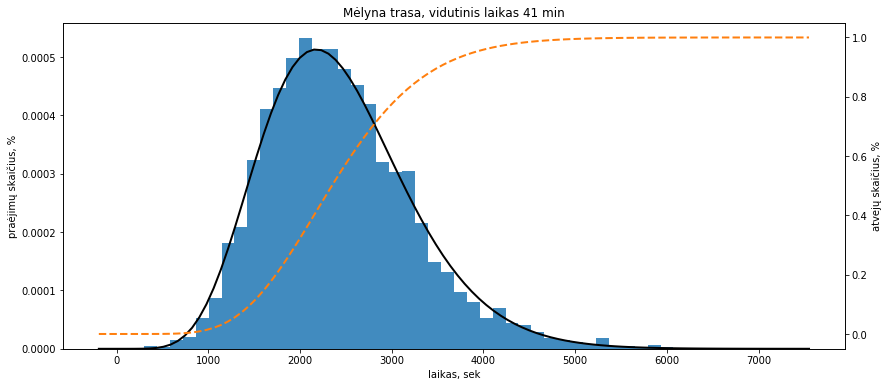

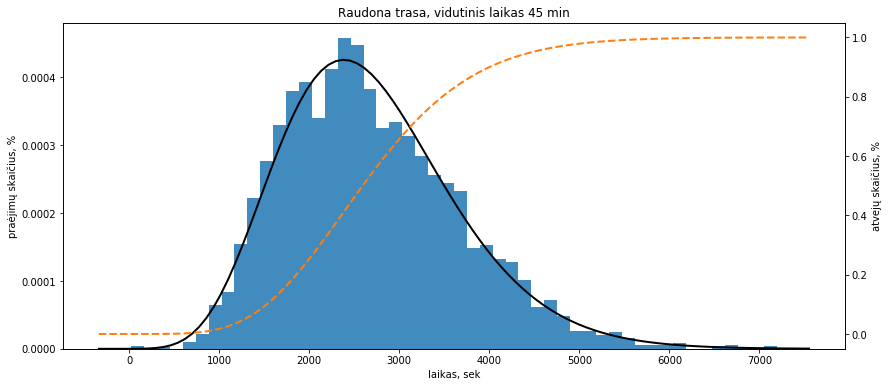

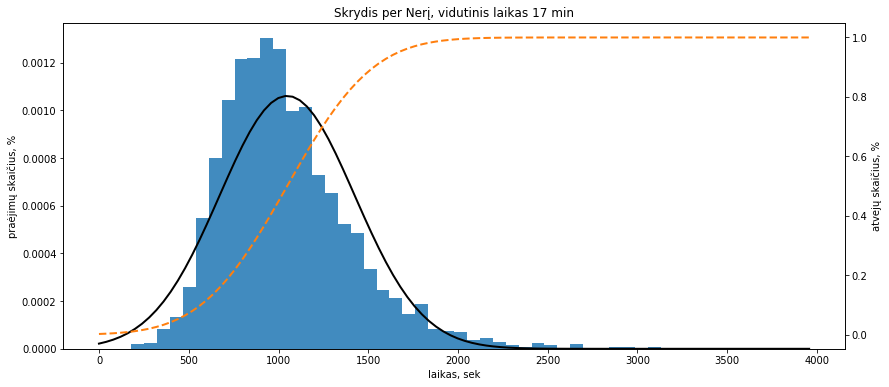

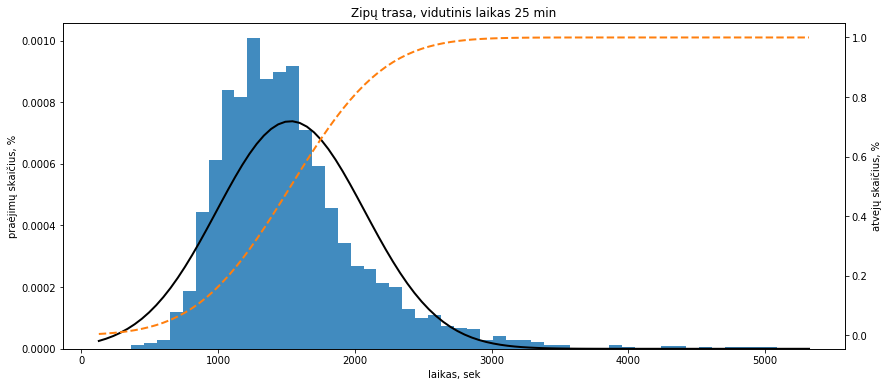

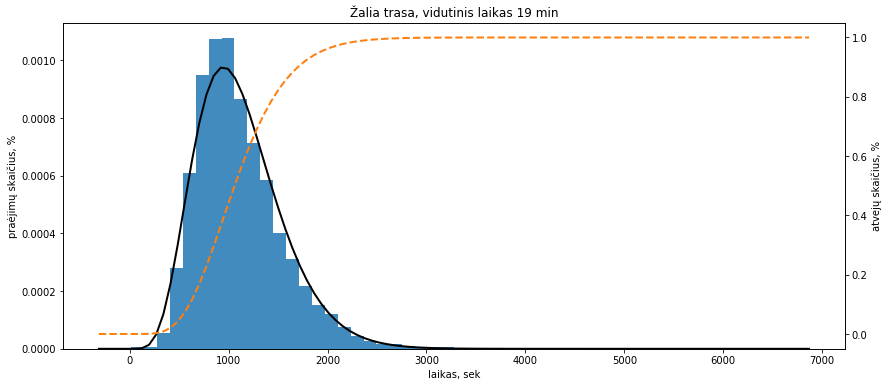

In [97]:
plt.rcParams['figure.figsize'] = (14, 6)
for t in np.unique(data[:, 0]):
    m = data[:, 0] == t
    
    d = times[m][:,1] - times[m][:,0]
    d = d[d > 0]
    
    if len(d) == 0: continue
    
    plt.close()
    fig, ax1 = plt.subplots()
    
    ax1.hist(d, bins = 50, density = True, alpha = 0.85, label = 'atvejų skaičius, %')
    ax2 = ax1.twinx()
    
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)

    if t != 'Zipų trasa' and t != 'Skrydis per Nerį':
        a, loc, scale = gamma.fit(d)
        ax1.plot(x, gamma.pdf(x, a, loc, scale), 'k', linewidth = 2, label = 'atvejų skaičiaus dažnio funkcija')
        ax2.plot(x, gamma.cdf(x, a, loc, scale), 'C1--', linewidth = 2, label = 'atvejų skaičiaus sankaupos funkcija')
        v = gamma.mean(a, loc, scale)
    else:
        v, s = norm.fit(d)
        ax1.plot(x, norm.pdf(x, v, s), 'k', linewidth = 2, label = 'atvejų skaičiaus dažnio funkcija')

        ax2.plot(x, norm.cdf(x, v, s), 'C1--', linewidth = 2, label = 'atvejų skaičiaus sankaupos funkcija')
        
    plt.title(f'{t}, vidutinis laikas {v/60:.0f} min')
    
    ax1.set_xlabel('laikas, sek')
    ax1.set_ylabel('praėjimų skaičius, %')
    ax2.set_ylabel('atvejų skaičius, %')
    #ax1.legend()
    plt.show()
    
    #if t == 'Zipų trasa': break


In [48]:
dates = np.array([datetime.fromtimestamp(ts).date() for ts in times[:,2]])
dates.shape

(29462,)

In [49]:
counts = np.array([ [i, datetime.combine(i, datetime.min.time()).timestamp(), len(dates[dates == i])] for i in np.unique(dates)])
counts.shape

(156, 3)

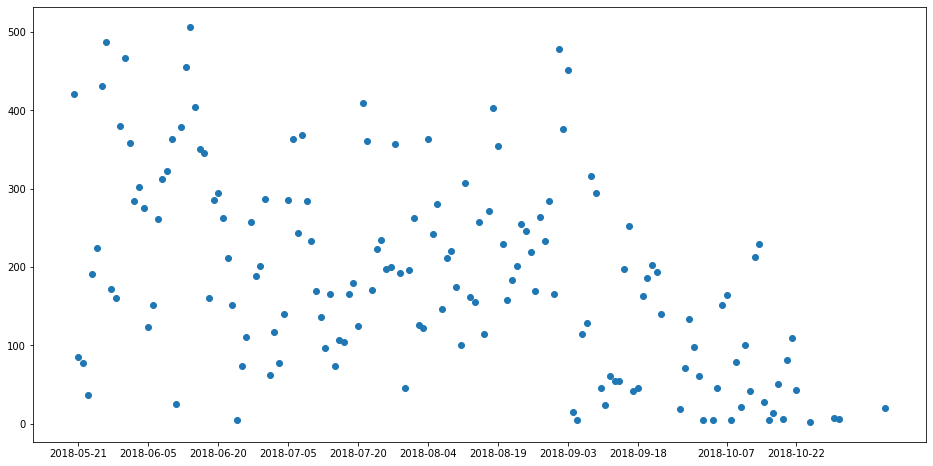

In [73]:
plt.scatter(counts[:,1], counts[:,2])
plt.xticks(counts[1::15,1], counts[1::15,0])
plt.show()

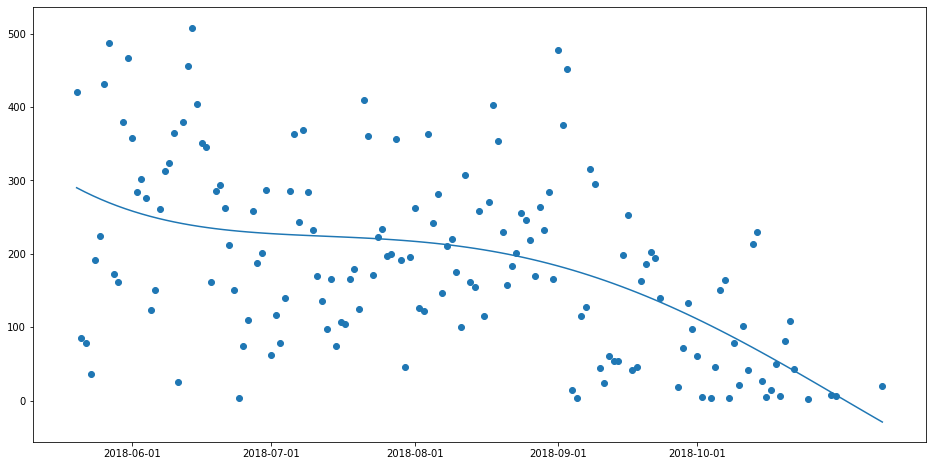

In [102]:
X = counts[:,1][:,np.newaxis].astype(int)
model = make_pipeline(PolynomialFeatures(7), Ridge())
model.fit(X, counts[:,2].astype(int))
x_line = np.linspace(np.min(X), np.max(X), 100)
y_plot = model.predict(x_line[:,np.newaxis])
plt.plot(x_line, y_plot)
plt.scatter(counts[:,1], counts[:,2])

def fdom(x): return x.day == 1 #or x.day == 15
m = np.array([fdom(i) for i in counts[:,0]])
plt.xticks(counts[m][:,1], counts[m][:,0])

plt.show()

In [112]:
wdays = np.array([[ datetime.fromtimestamp(ts).date().month, datetime.fromtimestamp(ts).date().weekday() ] for ts in times[:,2]])
wdays.shape

(29462, 2)

In [113]:
wcounts = np.array([ [i, len(dates[wdays[:,1] == i])] for i in np.unique(wdays[:,1])])
wcounts.shape

(7, 2)

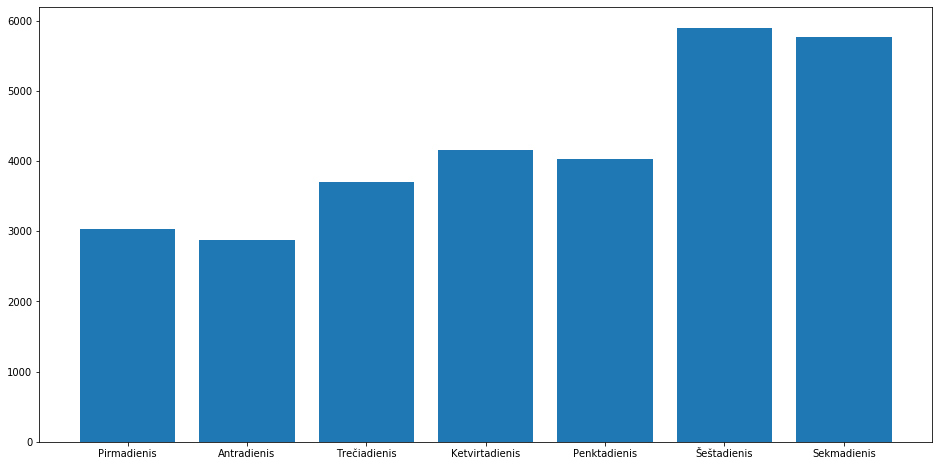

In [141]:
plt.bar(wcounts[:,0], wcounts[:,1])
plt.xticks(wcounts[:,0], WDAYS)
plt.show()

In [120]:
mwcounts = np.array([ [i[0], i[1], len(dates[(wdays[:,0] == i[0]) & (wdays[:,1] == i[1])])] for i in np.unique(wdays, axis=0)])
mwcounts.shape

(43, 3)

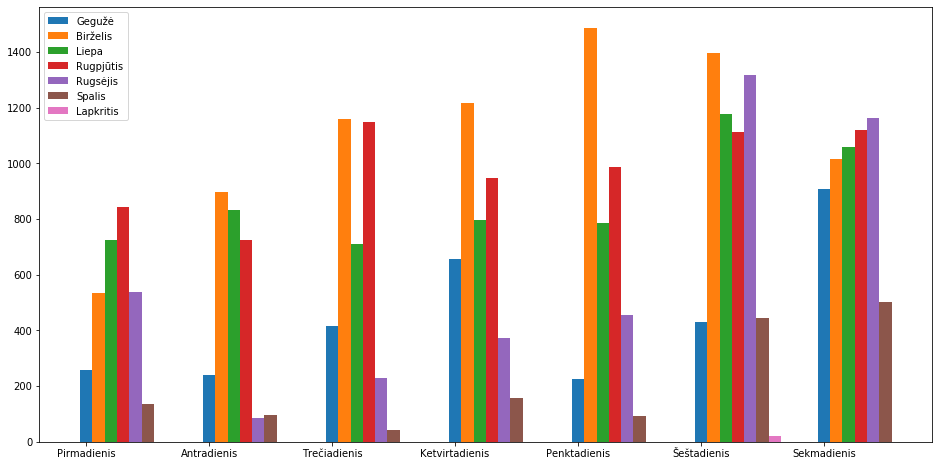

In [144]:
for i, m in enumerate(np.unique(mwcounts[:,0])):
    f = mwcounts[mwcounts[:,0] == m][:,1:]
    plt.bar(f[:,0] + 0.1 * i, f[:,1], width = 0.1, label = f'{MONTHS[m - 1]}')
    if i == 0:
        plt.xticks(f[:,0], WDAYS)
plt.legend()
plt.show()

In [154]:
d[:,0]

array(['Drambliaskrydis', 'Juoda trasa', 'Mėlyna trasa', 'Raudona trasa',
       'Skrydis per Nerį', 'Zipų trasa', 'Žalia trasa'], dtype='<U16')

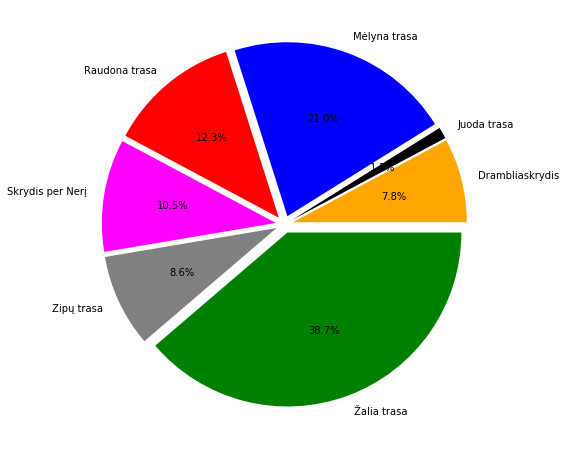

In [155]:
d = np.array([ [i, len(dates[data[:,0] == i])] for i in np.unique(data[:,0])])
c = ['orange', 'black', 'blue', 'red', 'magenta', 'grey', 'green']
plt.pie(d[:,1].astype(int), labels = d[:,0], autopct='%1.1f%%', explode = np.ones((len(d))) * 0.05, colors=c)
plt.show()

In [171]:
d = np.array([ [ np.mean(times[data[:,6] == i][:,3] - times[data[:,6] == i][:,2]), np.sum(times[data[:,6] == i][:,1] - times[data[:,6] == i][:,0]) ] for i in np.unique(data[:,6])])
d = d[d[:,1] > 0] / 60
d.shape

(7608, 2)

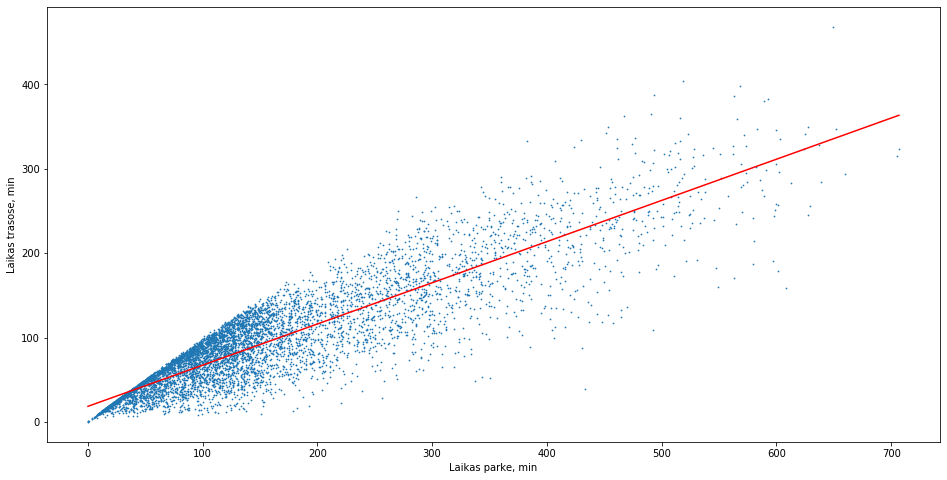

In [186]:
X = d[:,0][:,np.newaxis]
Y = d[:,1][:,np.newaxis]
model = LinearRegression()
model.fit(X, Y)
x_line = np.linspace(np.min(X), np.max(X), 100)
y_plot = model.predict(x_line[:,np.newaxis])
plt.plot(x_line, y_plot, c = 'red')
plt.scatter(X, Y, s= 0.5)
plt.xlabel('Laikas parke, min')
plt.ylabel('Laikas trasose, min')
plt.show()

In [184]:
model.coef_

array([[0.48802416]])

In [187]:
mcounts = np.array([ [i, len(dates[wdays[:,0] == i])] for i in np.unique(wdays[:,0])])
mcounts

array([[   5, 3133],
       [   6, 7710],
       [   7, 6085],
       [   8, 6882],
       [   9, 4161],
       [  10, 1471],
       [  11,   20]])

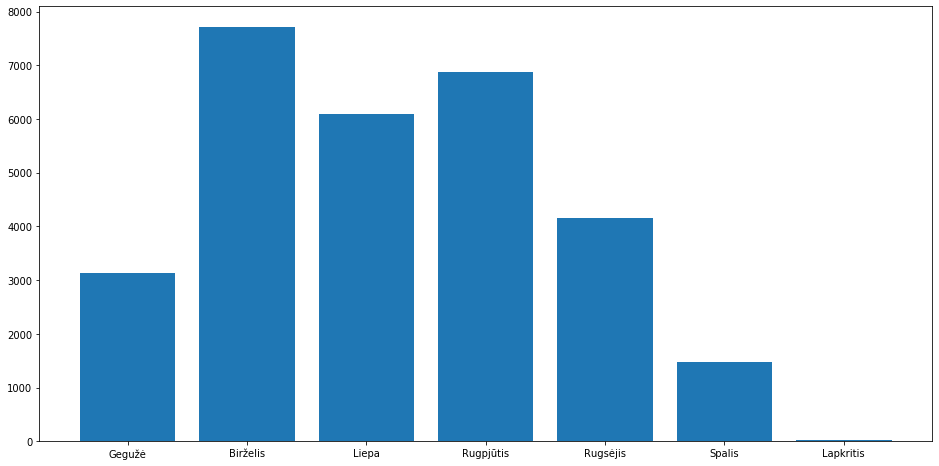

In [190]:
plt.bar(mcounts[:,0], mcounts[:,1])
plt.xticks(mcounts[:,0], np.array(MONTHS)[mcounts[:,0] - 1])
plt.show()

In [192]:
from mpl_toolkits.mplot3d import Axes3D

In [262]:
null = None
trasos = {
    'blue': {
        "type": "FeatureCollection",
        "name": "blue_track",
        "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:EPSG::3346" } },
        "features": [
            { "type": "Feature", "properties": { "Layer": "Blue_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CDFC", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ 24.013, -35.775, -0.581 ], [ 21.501, -28.694, -0.176 ] ] } },
            { "type": "Feature", "properties": { "Layer": "Blue_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE43", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ -31.741, -53.373, -2.006 ], [ -31.301, -49.006, -2.005 ], [ -13.693, 1.877, -0.435 ], [ -0.819, 8.092, 0.315 ], [ 7.935, 3.453, 0.303 ], [ 9.115, 1.482, 0.233 ], [ 18.76, -19.357, 0.103 ], [ 21.501, -28.694, -0.176 ] ] } },
            { "type": "Feature", "properties": { "Layer": "Blue_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE4D", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ -31.741, -53.373, -2.006 ], [ -32.561, -67.767, -2.511 ] ] } },
            { "type": "Feature", "properties": { "Layer": "Blue_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE51", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ -16.637, -47.21, -0.91 ], [ -14.691, -58.594, -1.446 ], [ -3.541, -63.294, -1.415 ], [ -11.034, -56.817, -1.273 ], [ 13.76, -43.407, -0.793 ], [ 14.956, -50.592, -1.016 ] ] } },
            { "type": "Feature", "properties": { "Layer": "Blue_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE59", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ 6.672, -5.826, 0.215 ], [ -0.819, 8.092, 0.315 ], [ -13.907, -46.175, -0.753 ], [ -16.637, -47.21, -0.91 ] ] } },
            { "type": "Feature", "properties": { "Layer": "Blue_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE5F", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ -10.942, -16.038, -0.249 ], [ -32.561, -67.767, -2.511 ] ] } },
            { "type": "Feature", "properties": { "Layer": "Blue_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE63", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ -10.942, -16.038, -0.249 ], [ -7.595, -4.916, -0.117 ], [ -1.139, -8.35, -0.018 ], [ 6.672, -5.826, 0.215 ] ] } }
        ]
    },
    'green': {
        "type": "FeatureCollection",
        "name": "green_track",
        "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:EPSG::3346" } },
        "features": [
            { "type": "Feature", "properties": { "Layer": "Green_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE00", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ 23.301, -36.228, -0.533 ], [ 15.97, -29.926, -0.254 ], [ 10.495, -26.216, -0.198 ], [ 6.194, -19.145, -0.103 ], [ 3.244, -25.498, -0.326 ], [ 6.621, -30.988, -0.341 ], [ -10.183, -23.199, -0.339 ], [ -10.647, -25.28, -0.334 ], [ -4.707, -28.889, -0.344 ], [ 2.171, -38.109, -0.407 ] ] } },
            { "type": "Feature", "properties": { "Layer": "Green_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE0C", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ 2.171, -38.109, -0.407 ], [ -14.691, -58.594, -1.446 ], [ -14.211, -62.399, -1.513 ], [ -13.538, -70.271, -1.699 ], [ -11.703, -76.567, -1.945 ], [ 11.946, -50.255, -0.962 ] ] } },
            { "type": "Feature", "properties": { "Layer": "Green_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE14", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ 11.946, -50.255, -0.962 ], [ 14.956, -50.592, -1.016 ] ] } }
        ]
    },
    'red': {
        "type": "FeatureCollection",
        "name": "red_track",
        "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:EPSG::3346" } },
        "features": [
            { "type": "Feature", "properties": { "Layer": "Red_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE18", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ 23.301, -36.228, -0.533 ], [ 13.76, -43.407, -0.793 ], [ 2.171, -38.109, -0.407 ], [ 7.731, -45.344, -0.705 ], [ 4.911, -50.27, -0.819 ] ] } },
            { "type": "Feature", "properties": { "Layer": "Red_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE1F", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ 4.911, -50.27, -0.819 ], [ -15.224, -90.906, -2.406 ], [ -28.503, -80.566, -2.621 ] ] } },
            { "type": "Feature", "properties": { "Layer": "Red_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE24", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ -28.503, -80.566, -2.621 ], [ -30.15, -86.243, -2.871 ], [ -22.541, -93.35, -2.768 ], [ -15.119, -104.918, -2.898 ], [ -15.224, -90.906, -2.406 ] ] } },
            { "type": "Feature", "properties": { "Layer": "Red_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE2B", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ -15.224, -90.906, -2.406 ], [ 47.039, -96.156, -2.511 ], [ 45.517, -101.324, -2.611 ], [ -3.583, -96.396, -2.226 ] ] } },
            { "type": "Feature", "properties": { "Layer": "Red_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE31", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ -3.583, -96.396, -2.226 ], [ -15.224, -90.906, -2.406 ], [ -5.611, -75.584, -1.678 ], [ 14.956, -50.592, -1.016 ], [ 13.19, -62.118, -1.377 ], [ 23.952, -42.773, -0.833 ] ] } },
            { "type": "Feature", "properties": { "Layer": "Red_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE39", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ 23.952, -42.773, -0.833 ], [ 69.323, -124.862, -2.076 ] ] } },
            { "type": "Feature", "properties": { "Layer": "Red_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE3D", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ 69.323, -124.862, -2.076 ], [ 60.964, -128.197, -2.46 ], [ 57.112, -135.977, -2.202 ], [ 53.265, -126.426, -2.947 ] ] } },
            { "type": "Feature", "properties": { "Layer": "Red_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE69", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ -3.583, -96.396, -2.226 ], [ -1.586, -105.645, -2.504 ], [ 6.248, -103.833, -2.122 ], [ 17.232, -96.721, -1.477 ], [ 23.284, -100.502, -1.635 ], [ 33.403, -104.028, -2.225 ], [ 52.321, -103.759, -2.507 ], [ 53.265, -126.426, -2.947 ] ] } }
        ]
    },
#     'tan': {
#         "type": "FeatureCollection",
#         "name": "tan_track",
#         "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:EPSG::3346" } },
#         "features": [
#             { "type": "Feature", "properties": { "Layer": "Tan_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE90", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ 13.19, -62.118, -1.377 ], [ 10.143, -64.43, -1.498 ], [ 4.801, -67.73, -1.411 ], [ 1.268, -70.649, -1.576 ], [ -5.611, -75.584, -1.678 ], [ 12.579, -84.285, -1.546 ], [ 15.692, -87.772, -1.466 ], [ 20.345, -85.126, -1.339 ], [ 16.166, -81.283, -1.462 ], [ 15.683, -78.076, -1.481 ], [ 12.937, -70.407, -1.542 ], [ 13.213, -67.105, -1.477 ], [ 13.19, -62.118, -1.377 ] ] } }
#         ]
#     },
#     'yellow': {
#         "type": "FeatureCollection",
#         "name": "yellow_track",
#         "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:EPSG::3346" } },
#         "features": [
#             { "type": "Feature", "properties": { "Layer": "Yellow_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE73", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ 30.157, -61.922, -1.237 ], [ 39.053, -89.685, -1.555 ], [ 42.782, -86.988, -1.596 ], [ 46.894, -93.687, -2.169 ], [ 42.703, -93.672, -2.073 ], [ 37.696, -91.463, -1.666 ], [ 28.024, -60.516, -1.294 ], [ 25.375, -63.56, -1.32 ], [ 26.942, -69.457, -1.253 ], [ 32.042, -85.016, -1.156 ] ] } },
#             { "type": "Feature", "properties": { "Layer": "Yellow_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE7F", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ 32.042, -85.016, -1.156 ], [ 30.467, -91.226, -1.309 ], [ 24.506, -84.229, -1.196 ], [ 23.685, -80.659, -1.197 ], [ 23.082, -63.204, -1.361 ], [ 23.384, -60.18, -1.318 ] ] } },
#             { "type": "Feature", "properties": { "Layer": "Yellow_track", "SubClasses": "AcDbEntity:AcDb3dPolyline", "ExtendedEn": null, "Linetype": null, "EntityHand": "4CE87", "Text": null }, "geometry": { "type": "LineString", "coordinates": [ [ 23.384, -60.18, -1.318 ], [ 24.016, -57.147, -1.232 ], [ 23.471, -57.522, -1.231 ], [ 21.282, -58.478, -1.302 ], [ 24.108, -54.26, -1.236 ], [ 25.556, -54.121, -1.278 ], [ 24.016, -57.147, -1.232 ] ] } }
#         ]
#     }
}

In [263]:
lines = []
for i, l in enumerate(trasos.keys()):
    for j, f in enumerate(trasos[l]["features"]):
        for c in f["geometry"]["coordinates"]:
            lines.append([ l, i * 100 + j, c[0], c[1], c[2] ])
lines = np.array(lines)

In [264]:
lines

array([['blue', '0', '24.013', '-35.775', '-0.581'],
       ['blue', '0', '21.501', '-28.694', '-0.176'],
       ['blue', '1', '-31.741', '-53.373', '-2.006'],
       ['blue', '1', '-31.301', '-49.006', '-2.005'],
       ['blue', '1', '-13.693', '1.877', '-0.435'],
       ['blue', '1', '-0.819', '8.092', '0.315'],
       ['blue', '1', '7.935', '3.453', '0.303'],
       ['blue', '1', '9.115', '1.482', '0.233'],
       ['blue', '1', '18.76', '-19.357', '0.103'],
       ['blue', '1', '21.501', '-28.694', '-0.176'],
       ['blue', '2', '-31.741', '-53.373', '-2.006'],
       ['blue', '2', '-32.561', '-67.767', '-2.511'],
       ['blue', '3', '-16.637', '-47.21', '-0.91'],
       ['blue', '3', '-14.691', '-58.594', '-1.446'],
       ['blue', '3', '-3.541', '-63.294', '-1.415'],
       ['blue', '3', '-11.034', '-56.817', '-1.273'],
       ['blue', '3', '13.76', '-43.407', '-0.793'],
       ['blue', '3', '14.956', '-50.592', '-1.016'],
       ['blue', '4', '6.672', '-5.826', '0.215'],
      

<IPython.core.display.Javascript object>


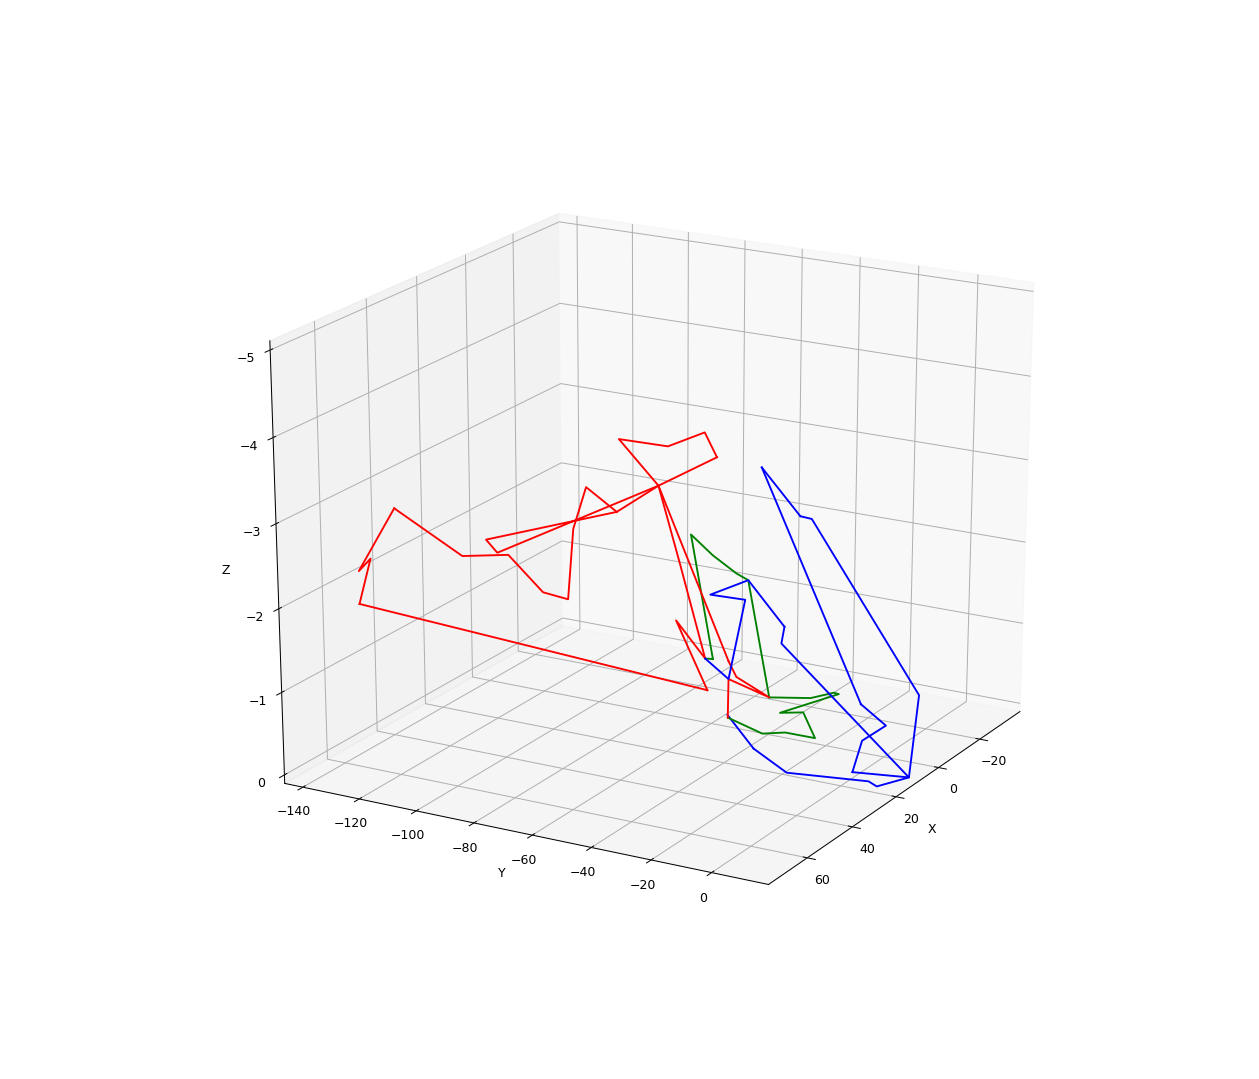

In [268]:
plt.rcParams['figure.figsize'] = (14, 12)
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in np.unique(lines[:,1]):
    cut = c = lines[lines[:,1] == i]
    c = cut[0,0]
    d = cut[:,2:].astype(float)
    ax.plot(d[:,0], d[:,1], d[:,2], c = c)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim(0, -5)
plt.show()